In [1]:
%matplotlib inline

# 训练一个分类器

我们可以使用`torchvision`来处理图像。

>一般情况下处理图像、文本、音频和视频数据时，可以使用标准的Python包来加载数据到一个numpy数组中。 然后把这个数组转换成 torch.*Tensor。
图像可以使用 Pillow, OpenCV
音频可以使用 scipy, librosa
文本可以使用原始Python和Cython来加载，或者使用 NLTK或 SpaCy 处理

>特别的，对于图像任务，我们创建了一个包 torchvision，它包含了处理一些基本图像数据集的方法。这些数据集包括 Imagenet, CIFAR10, MNIST 等。除了数据加载以外，torchvision 还包含了图像转换器， torchvision.datasets 和 torch.utils.data.DataLoader。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

`transforms = transforms.Compose(transforms)`定义一个变换，该变换将将多个变换步骤整合在一起。
* `ToTensor()`将数值范围为[0,255]的PIL图像转换为[0,1]的 Tensor。
* `Normalize(mean, deviation)`给定均值和标准差，进行归一化处理。这里图像为 RGB 三个通道，因而需要为三个通道都赋予参数。

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane','car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
?torchvision.datasets.CIFAR10

In [5]:
import matplotlib.pyplot as plt
import numpy as np

写一个展示图片的函数。

In [6]:
def imshow(img):
    img = img/2+0.5    # 归一化公式 (x-0.5)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0))) #将各个维度的顺序重新排列

In [7]:
?torch.nn.functional.normalize

首先`ToTensor`就已经标准化了。然后`Normalize`用了这个 $v = \frac{v}{\max(\lVert v \rVert_p, \epsilon)}$  看不懂的归一化公式。在这里是`(x-0.5)*2`将范围为[0,1]的 x 变成范围[-1,1]

`Dataload`创建一个可迭代对象，类似一个列表，每个列表的两个元素的为图片和标签，可以通过`iter()`的方式访问并用`next()`的方式读取。

dog truck plane deer


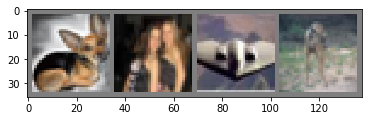

In [8]:
#获取随机数据   看不懂
dataiter = iter(trainloader)
images, labels = dataiter.next()  

#展示4个图像
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))


## 神经网络。

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Loss & Optimizer

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train

In [11]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #在trainloader的每个元素(tuple)前添加一项作为序号,从0开始
        inputs, labels = data
        optimizer.zero_grad()
        
        #data为迭代对象的一项，相当于列表的一个元素。
        
        #输入一个图片，计算loss，反向传播，每个loss
        outputs = net(inputs)        
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        #下面涉及到batch的概念，但是要明确，我们这里并没有使用mini-batch梯度下降，而是对每个样本进行梯度下降
        #下面打印损失,2000样本为一个batch，每个batch对应一个总的loss，一个batch后重置loss
        running_loss += loss.item()
        if i%2000==1999:
            print('[%d,%5d] loss: %.3f'%
                 (epoch+1, i+1, running_loss/2000))
            running_loss=0.0

[1, 2000] loss: 2.216
[1, 4000] loss: 1.864
[1, 6000] loss: 1.657
[1, 8000] loss: 1.556
[1,10000] loss: 1.499
[1,12000] loss: 1.444
[2, 2000] loss: 1.344
[2, 4000] loss: 1.348
[2, 6000] loss: 1.322
[2, 8000] loss: 1.297
[2,10000] loss: 1.280
[2,12000] loss: 1.249


## 测试

迭代对象的知识不太了解，但是在这里可以看出，这个迭代对象中，每取一次是4张图片,原因是`Dataload`的参数中`batch_size`被设置为`4`，所以这里也算是一种 minibatch

GroundTruth: cat ship ship plane


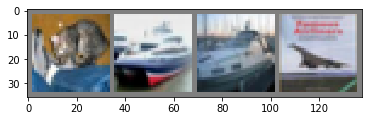

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join(classes[labels[j]] for j in range(4)))

看看神经网络认为是什么

In [13]:
outputs = net(images) #输入四张图片

In [14]:
outputs    #输出四个图片的分类结果

tensor([[-1.4314, -1.8607,  1.2158,  1.9903,  0.1784,  1.3091,  1.9610, -0.7239,
         -0.2134, -1.6827],
        [ 5.9921,  5.9089, -1.7006, -3.7653, -2.2897, -5.4844, -4.4466, -4.8706,
          5.1248,  3.0223],
        [ 3.9258,  2.1260,  0.1937, -1.9149, -0.9345, -3.6225, -3.0808, -2.9640,
          3.4474,  0.6004],
        [ 5.2951,  1.6279,  0.4135, -2.6603, -0.3151, -4.0286, -3.2645, -2.5867,
          3.6011,  0.1990]], grad_fn=<AddmmBackward>)

`torch.max(tensor, dim)`两个参数,一个是输入的`tensor`，另一个是维度数`dim`，0就是每一列作比较得出最大值，1是每一行作比较得出最大值。

In [15]:
value, pridict = torch.max(outputs, 1) 
print(pridict)
print('pridict: ', ' '.join(classes[pridict[j]] for j in range(4)))

tensor([3, 0, 0, 0])
pridict:  cat plane plane plane


查看整个数据集的表现。

In [16]:
correct = 0
total = 0
with torch.no_grad(): 
    for data in testloader: 
        images, labels = data
        outputs = net(images)
        value, pridict = torch.max(outputs.data, 1)
        total += labels.size(0) #labels是一个list，长度为
        correct += (pridict == labels).sum().item()

以下是对两个 Tensor 使用`==`计算的示例，很显然这就类似词向量那里要用到的那个什么东西名字忘了。

In [17]:
print('Accuracy: %d %%'%(100*correct/total))

Accuracy: 53 %


In [18]:
a = torch.Tensor([1,2,3,4])
b = torch.Tensor([2,2,3,1])
print(a == b)
print((a==b).sum())#.sum方法计算出来还是tensor
print((a==b).squeeze()) # .squeeze(dim)为如果第dim个维度的为维度值为1，那就去掉这个维度，因为没用，如果没指定dim那就是去掉全部没用的维度

tensor([0, 1, 1, 0], dtype=torch.uint8)
tensor(2)
tensor([0, 1, 1, 0], dtype=torch.uint8)


如何计算每一个类别的准确率呢，我们只需要把`correct`和`total`写成一个长度为10的向量就可以啦！

In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        value, pridict = torch.max(outputs, 1)
        c = (pridict == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item() #加上0或者1
            class_total[label] += 1
            

In [23]:
for i in range(10):
    print('Accuracy of %5s : %2d%%'%
          (classes[i], class_correct[i]*100/class_total[i]))

Accuracy of plane : 78%
Accuracy of   car : 80%
Accuracy of  bird : 36%
Accuracy of   cat : 17%
Accuracy of  deer : 50%
Accuracy of   dog : 50%
Accuracy of  frog : 67%
Accuracy of horse : 64%
Accuracy of  ship : 45%
Accuracy of truck : 43%


## GPU上训练

只需要将每次input的tensor(labels 和 inputs)，以及整个net转移到gpu,即`to(device)`即可。